___
# <span style="color:red"> **PROJET CYCLE-GAN POUR ADAPTATION DE DOMAINE (MNIST -> SVHN)** </span>
___

***Pre-scriptum** : Le notebook à subit sa phase d'entrainement sur Kaggle (pour pouvoir user du gpu) c'est pour cela que les sorties ne sont pas affichées. (le train prend environ 1h30)*

> **OBJECTIF**

L'objectif est double.

- Dans un premier temps, entraîner un cycle GAN capable de transformer MNIST <-> SVHN.

- Dans un second temps, créer un CNN que l'on entraînera sur la génération de SVHN (créé à partir de MNIST). Une fois entrainé, le dataset de test sera, lui, celui de SVHN. 

Le résultat espéré et de pouvoir entraîner sur une base de données créé à partir d'une transformation de domaine.

___
## <span style="color:red"> **Explication de l'architecture** 
___

En 2017, *Jun-Yan Zhu, Taesung Park, Phillip Isola, Alexei A. Efros*, sorte un papier ***Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks***.

Ils y décrivent le moyen de réaliser une cartographie d'une image d'entrée vers une image de sortie sans image paire. 

<center>
<img src="../Images/zebtohors.png" width="1000">
</center>

Pour obtenir ce résultat nous entrainons deux cycles de générateurs. Chaque cycle auras un discriminateur qui cherchera à détecter le vrai du faux (ici nous rajoutons un élément supplémentaire que sont les labels afin d'aider les générateurs dans leurs réalisations).

<center>
<img src="../Images/adapt_domaine.png" width="1000" >  
</center>

**Objectif :** Le projet se sépare en deux étapes. 
- Premièrement, nous devont générer des images en couleur du jeu de donnée MNIST à l'aide d'un GAN et du jeu SVHN.
- Deuxièmement, Une foix ces nouvelles images générées, nous en servons comme entrainnement pour prédire le test de SVHN.

___
## <span style="color:red"> **Librairie en usage pour le projet**
___

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np

import imageio

import os

from tqdm import tqdm


___
## <span style="color:red"> Partie 1 : Generation des MNIST en couleur et des SVHN en N&B
___

___
### <span style="color:red"> **I.I BLOCK CONV & DECONV**
___

Cette section regroupe les blocs *conv* et *deconv* qui sont récurrents dans les réseaux. 

L'objectif est de gagner en lisibilité.

In [ ]:
def conv(in_chan, out_chan, kern_size, stride = 2, pad = 1, bn=True):
    
    layers = []
    
    layers.append(nn.Conv2d(in_chan, out_chan, kern_size, stride, pad))
    # Certaines couche du réseau n'utilise pas de batchnorm, on rajoute donc une condition (bn) à son usage.
    if bn:
        layers.append(nn.BatchNorm2d(out_chan))

    return nn.Sequential(*layers)

In [ ]:
def deconv(in_chan, out_chan, kern_size, stride = 2, pad = 1, bn = True):

    layers = []

    layers.append(nn.ConvTranspose2d(in_chan, out_chan, kern_size, stride, pad))
    # Certaines couche du réseau n'utilise pas de batchnorm, on rajoute donc une condition (bn) à son usage.
    if bn:
        layers.append(nn.BatchNorm2d(out_chan))

    return nn.Sequential(*layers)


___
### <span style="color:red"> **I.II. DISCRIMINATOR**
___

Ici sont construits les deux modules de discrimination.

Leur objectif respectif est de détecter le vrai du faux. 

<center>
<img src="../Images/discri.png" width="300" >  
</center>

Dans notre implémentation nous rajoutons un élément out = 11 qui correspondent à une aide pour les générateurs à identifier les chiffres.

Théoriquement le cycle Gan est capable de retrouver les labels spécifiques (par le principe du cycle).


Cependant nous sommes dans un cas de figure où les deux domaines ont des labels identiques, il est donc pertinent de les utiliser lors de la phase d'entrainement afin de soulager le travail de l'adaptation de domaine.

In [ ]:
CONV_DIM = 64

In [ ]:
# MNIST DISCRIMINATOR

class Discriminator_MNIST(nn.Module):
    def __init__(self, conv_dim = CONV_DIM):
        
        super(Discriminator_MNIST, self).__init__()
        self.conv1 = conv(in_chan = 1, out_chan = conv_dim, kern_size = 4, bn = False)
        self.conv2 = conv(in_chan = conv_dim, out_chan = conv_dim*2, kern_size = 4)
        self.conv3 = conv(in_chan = conv_dim*2, out_chan = conv_dim*4, kern_size = 4)

        n_out = 11

        self.fc = conv(in_chan = conv_dim*4, out_chan = n_out, kern_size = 4, stride = 1, pad = 0, bn = False)


    def forward(self,x):
        x = F.leaky_relu(self.conv1(x), 0.05) 
        x = F.leaky_relu(self.conv2(x), 0.05) 
        x = F.leaky_relu(self.conv3(x), 0.05) 
        
        x = self.fc(x).squeeze()

        return x


In [ ]:
# SVHN DISCRIMINATOR

class Discriminator_SVHN(nn.Module):
    def __init__(self, conv_dim = CONV_DIM):
        
        super(Discriminator_SVHN, self).__init__()
        self.conv1 = conv(in_chan = 3, out_chan = conv_dim, kern_size = 4, bn = False)
        self.conv2 = conv(in_chan = conv_dim, out_chan = conv_dim*2, kern_size = 4)
        self.conv3 = conv(in_chan = conv_dim*2, out_chan = conv_dim*4, kern_size = 4)

        n_out = 11

        self.fc = conv(in_chan = conv_dim*4, out_chan = n_out, kern_size = 4, stride = 1, pad = 0, bn = False)


    def forward(self,x):
        x = F.leaky_relu(self.conv1(x), 0.05)
        x = F.leaky_relu(self.conv2(x), 0.05)
        x = F.leaky_relu(self.conv3(x), 0.05)        
        x = self.fc(x).squeeze()

        return x


___
### <span style="color:red"> **I.III. GENERATOR**
___

On crée les générateur.

L'architecture est identique pour les deux : Encoding Block -> Residual Bloc -> Decoder Block

Dans le papier de 2017 nous pouvions retrouver une architecture telle que ci-dessous :


<center>
<img src="../Images/generator.png" width="600" >  
</center>


Dans cette adaptation, nous ne mettons que 2 couches par block.



In [ ]:
class GeneratorMNISTtoSVHN(nn.Module):
    def __init__(self, conv_dim = 64):

        super(GeneratorMNISTtoSVHN, self).__init__()

        # Encoding Block
        self.conv1 = conv(in_chan = 1, out_chan = conv_dim, kern_size = 4)
        self.conv2 = conv(in_chan = conv_dim, out_chan = conv_dim*2, kern_size = 4)

        # Residual Block
        self.conv3 = conv(in_chan = conv_dim*2, out_chan = conv_dim*2, kern_size = 3, stride = 1, pad=1)
        self.conv4 = conv(in_chan = conv_dim*2, out_chan = conv_dim*2, kern_size = 3, stride = 1, pad=1)

        # Decoder Block
        self.deconv1 = deconv(in_chan = conv_dim*2, out_chan = conv_dim, kern_size = 4)
        self.deconv2 = deconv(in_chan = conv_dim, out_chan = 3, kern_size = 4, bn = False)




    def forward(self, x):
        # Encode
        x = F.leaky_relu(self.conv1(x), 0.05)
        x = F.leaky_relu(self.conv2(x), 0.05)
        
        # Residual
        x = F.leaky_relu(self.conv3(x), 0.05)
        x = F.leaky_relu(self.conv4(x), 0.05)

        # Decode 
        x = F.leaky_relu(self.deconv1(x), 0.05)
        x = torch.tanh(self.deconv2(x))

        return x

In [ ]:
class GeneratorSVHNtoMNIST(nn.Module):
    def __init__(self, conv_dim = 64):

        super(GeneratorSVHNtoMNIST, self).__init__()

        # Encoding Block
        self.conv1 = conv(in_chan = 3, out_chan = conv_dim, kern_size = 4)
        self.conv2 = conv(in_chan = conv_dim, out_chan = conv_dim*2, kern_size = 4)

        # Residual Block
        self.conv3 = conv(in_chan = conv_dim*2, out_chan = conv_dim*2, kern_size = 3, stride = 1, pad=1)
        self.conv4 = conv(in_chan = conv_dim*2, out_chan = conv_dim*2, kern_size = 3, stride = 1, pad=1)

        # Decoder Block
        self.deconv1 = deconv(in_chan = conv_dim*2, out_chan = conv_dim, kern_size = 4)
        self.deconv2 = deconv(in_chan = conv_dim, out_chan = 1, kern_size = 4, bn = False)

    def forward(self, x):
        # Encode
        x = F.leaky_relu(self.conv1(x), 0.05)
        x = F.leaky_relu(self.conv2(x), 0.05)
        
        # Residual
        x = F.leaky_relu(self.conv3(x), 0.05)
        x = F.leaky_relu(self.conv4(x), 0.05)

        # Decode 
        x = F.leaky_relu(self.deconv1(x), 0.05)
        x = torch.tanh(self.deconv2(x))

        return x

___
### <span style="color:red"> **I.IV. Chargement des données**
___

L'architecture global est maintenant fini.

On cherche à charger nos données.

In [ ]:
def load_MNIST():

    transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    ]
    )

    mnist = datasets.MNIST(root='data', train=True, download=True, transform=transform)

    mnist_loader = torch.utils.data.DataLoader(dataset=mnist,
                                        batch_size=64,
                                        shuffle=True,
                                        num_workers=2)

    return mnist_loader

In [ ]:
def load_SVHN():

    transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    ]
    )

    svhn = datasets.SVHN(root='data', split = 'train', download=True, transform=transform)

    svhn_loader = torch.utils.data.DataLoader(dataset=svhn,
                                        batch_size=64,
                                        shuffle=True,
                                        num_workers=2)

    return svhn_loader

> Test loader

In [ ]:
def loader_img():
    return load_MNIST(), load_SVHN()

In [ ]:
def image_show(data_loader,n):

  #Read Augmented image data
  tmp = iter(data_loader)
  images,labels = tmp.next()

  #Convert image from tensor to numpy
  images = images.numpy()

  #Take out n images one by one and display them
  for i in range(n):
    image = np.transpose(images[i],[1,2,0])
    print(images[i].shape)
    plt.imshow(image)
    plt.show()

In [ ]:
im1, im2 = loader_img()

In [ ]:
image_show(im1, 1)

In [ ]:
image_show(im2, 1)

___
## <span style="color:red"> **I.V. TRAIN LOOP**
___

Les fonctions de load sont opérationnelles avec les data loaders. 

Il est temps de créer la fonction de loop.

In [ ]:
# On reprend les hypeparams du doc

LEARNING_RATE = 2e-4
BETAS = [0.5, 0.999]

In [ ]:
train_iters = 40000 # EPOCHS = train_iters / batch_size (=64 içi)

sample_path = "./GenImage2"

save_path = "./SaveModel"

In [ ]:
# Si n'existe pas crée les fichiers
os.mkdir(sample_path)
os.mkdir(save_path)

A chaque étape du train on pense bien à mettre les optimizer à zeros avec zero_grad()

In [ ]:
#################################
### CREATE THE TRAIN FONCTION ###
#################################

def train_fn(disc_M, disc_S, gen_M, gen_S, loader_mnist, loader_svhn, opt_disc, opt_gen):

    # Initialisation du premier Batch
    svhn_iter = iter(loader_svhn)
    mnist_iter = iter(loader_mnist)

    iter_per_epoch = min(len(svhn_iter), len(mnist_iter))

    # fixed mnist & svhn pour le sampling de test 
    # fixed_svhn = (svhn_iter.next()[0]).cuda()
    # fixed_mnist = (mnist_iter.next()[0]).cuda()

    # Dans notre cas avec les labels nous utilisons en plus une crossEntropy    
    criterion = nn.CrossEntropyLoss()
    
    
    for step in tqdm(range(train_iters+1)):
            # recharge un nouveau pour chaque EPOCH
            if (step+1) % iter_per_epoch == 0:
                mnist_iter = iter(loader_mnist)
                svhn_iter = iter(loader_svhn)
            
            # Parcour les batch 
            svhn, s_labels = svhn_iter.next() 
            svhn, s_labels = svhn.cuda(), s_labels.cuda().long().squeeze()
            mnist, m_labels = mnist_iter.next() 
            mnist, m_labels = mnist.cuda(), m_labels.cuda()
            
            
            #### Création des labels pour les FAKE ####
            mnist_fake_labels = (torch.Tensor([10]*svhn.size(0)).long()).cuda() # 10 is the classes for the FAKE element
            svhn_fake_labels = (torch.Tensor([10]*mnist.size(0)).long()).cuda()
    
    
            ###### TRAIN DISCRIMINATORS ######            

                # TRAIN REAL IMAGE #
            opt_disc.zero_grad()
            opt_gen.zero_grad()

            disc_mnist_real = disc_M(mnist)
            disc_mnist_real_loss = criterion(disc_mnist_real, m_labels) 
            
            disc_svhn_real = disc_S(svhn)
            disc_svhn_real_loss = criterion(disc_svhn_real, s_labels)  

            d_real_loss = disc_mnist_real_loss + disc_svhn_real_loss

            d_real_loss.backward()
            opt_disc.step()

                # TRAIN FAKE IMAGE #

            opt_gen.zero_grad()
            opt_disc.zero_grad()
            
            fake_mnist= gen_M(svhn)
            disc_mnist_fake = disc_M(fake_mnist)
            disc_mnist_fake_loss =  criterion(disc_mnist_fake, mnist_fake_labels) 
            
            fake_svhn = gen_S(mnist)
            disc_svhn_fake = disc_S(fake_svhn)
            disc_svhn_fake_loss = criterion(disc_svhn_fake, svhn_fake_labels)

            d_fake_loss = disc_mnist_fake_loss + disc_svhn_fake_loss

            d_fake_loss.backward()
            opt_disc.step()


            ###### TRAIN GENERATOR ######  
            
            opt_gen.zero_grad()
            opt_disc.zero_grad()
            
                # Train MNIST -> SVHN -> MNIST cycle #
            fake_svhn = gen_S(mnist) 
            disc_svhn_fake = disc_S(fake_svhn)
            reconst_mnist = gen_M(fake_svhn)

            g_loss =  criterion(disc_svhn_fake, m_labels) + torch.mean((mnist - reconst_mnist)**2)

            g_loss.backward()
            opt_gen.step()

                # Train SVHN -> MNIST -> SVHN cycle #
            opt_gen.zero_grad()
            opt_disc.zero_grad()
            
            fake_mnist = gen_M(svhn) 
            disc_mnist_fake = disc_M(fake_mnist)
            reconst_svhn = gen_S(fake_mnist)

            g_loss = criterion(disc_mnist_fake, s_labels) + torch.mean((svhn - reconst_svhn)**2)

            g_loss.backward()
            opt_gen.step()



            # save the sampled images
            # save_sample(step = step, fixed_mnist = fixed_mnist, fixed_svhn = fixed_svhn)
                
            # save the params net
            # save_params(step = step)



In [ ]:
# Fonction pour sauvegarder les images et les paramètres

def save_sample(step, fixed_mnist, fixed_svhn):
    if (step+1) % 1000 == 0:
            fake_svhn = gen_S(fixed_mnist)
            fake_mnist = gen_M(fixed_svhn)
            
            mnist, fake_mnist = fixed_mnist.cpu(), fake_mnist.cpu()
            svhn , fake_svhn = fixed_svhn.cpu(), fake_svhn.cpu()

            path = os.path.join(sample_path, 'sample-svhn-%d-m-s.png' %(step+1))
            imageio.imwrite(path, fake_svhn[0].cpu().detach().numpy().transpose(1, 2, 0))
            path = os.path.join(sample_path, 'real-svhn-%d-m-s.png' %(step+1))
            imageio.imwrite(path, svhn[0].cpu().detach().numpy().transpose(1, 2, 0))
            print ('saved %s' %path)


            path = os.path.join(sample_path, 'sample-mnist-%d-s-m.png' %(step+1))
            imageio.imwrite(path, fake_mnist[0].cpu().detach().numpy().transpose(1, 2, 0))
            path = os.path.join(sample_path, 'real-mnist-%d-m-s.png' %(step+1))
            imageio.imwrite(path, mnist[0].cpu().detach().numpy().transpose(1, 2, 0))
            print ('saved %s' %path)


def save_params(step) : 
            if (step+1) % 1000 == 0:
                # save the model parameters for each epoch
                gMtoS_path = os.path.join(save_path, '%d-gMtoS.pkl' %(step+1))
                gStoM_path = os.path.join(save_path, '%d-gStoM.pkl' %(step+1))
                dM_path = os.path.join(save_path, '%d-dM.pkl' %(step+1))
                dS_path = os.path.join(save_path, '%d-dS.pkl' %(step+1))
                torch.save(gen_S.state_dict(), gMtoS_path)
                torch.save(gen_M.state_dict(), gStoM_path)
                torch.save(disc_M.state_dict(), dM_path)
                torch.save(disc_S.state_dict(), dS_path)


In [ ]:
disc_M = Discriminator_MNIST()
disc_S = Discriminator_SVHN()
gen_M = GeneratorSVHNtoMNIST()
gen_S = GeneratorMNISTtoSVHN()

opt_disc = torch.optim.Adam(
                            list(disc_M.parameters()) + list(disc_S.parameters()),
                            lr = LEARNING_RATE,
                            betas = BETAS
                            )

opt_gen = torch.optim.Adam(
                            list(gen_M.parameters()) + list(gen_S.parameters()),
                            lr = LEARNING_RATE,
                            betas = BETAS
                            )

if torch.cuda.is_available():
        disc_M.cuda()
        disc_S.cuda()
        gen_M.cuda()
        gen_S.cuda()



train_fn(disc_M, disc_S, gen_M, gen_S, load_MNIST(), load_SVHN(), opt_disc, opt_gen)
        
  



In [ ]:
print("#####DONE#####")

## RESULT

Le résultats des images Save sont affichées dans le désordre.

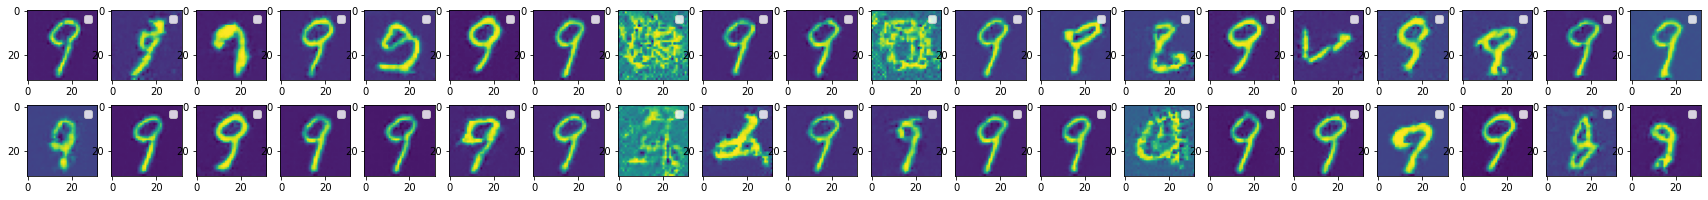

In [28]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

images = []
for img_path in glob.glob('GenImage/sample-mnist-*.png'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(30,5))
columns = 20
for i, image in enumerate(images):
    plt.subplot(int(len(images) / columns + 1), columns, i + 1)
    plt.legend("{}".format(i))
    plt.imshow(image)


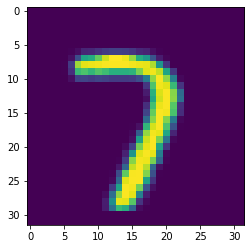

In [36]:
images = []
for img_path in glob.glob('GenImage/real-mnist-*.png'):
    images.append(mpimg.imread(img_path))

images = (mpimg.imread(img_path))
plt.imshow(images)

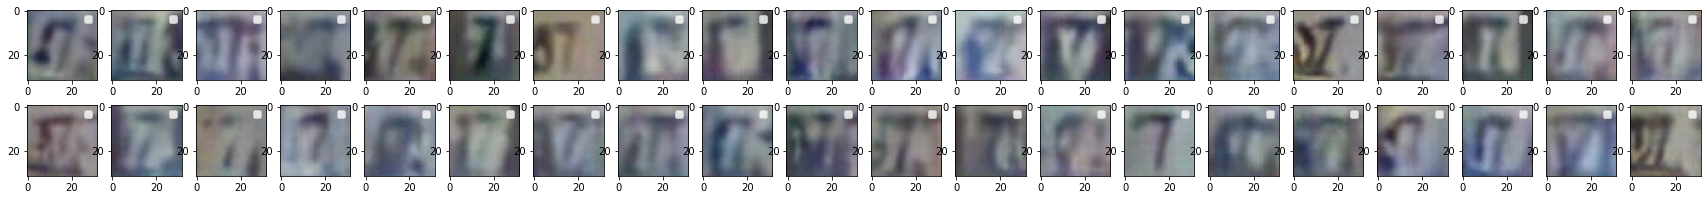

In [26]:
images = []
for img_path in glob.glob('GenImage/sample-svhn-*.png'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(30,5))
columns = 20
for i, image in enumerate(images):
    plt.subplot(int(len(images) / columns + 1), columns, i + 1)
    plt.legend("{}".format(i))
    plt.imshow(image)